<a href="https://colab.research.google.com/github/wanda15tw/Kaggle/blob/master/Keras_Flowers_transfer_learning_(playground).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please select a GPU backend for this notebook. It uses pre-trained models in tf.keras.applications.* which are not TPU-compatible yet

## Imports

In [1]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 1.14.0-rc1


## Colab-only auth
You would need this if you were accessing private GCS buckets. The training data for this exercise is in a public bucket for which authentication is not necessary.

In [0]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user()  # not necessary to access a public bucket but you will probably want to access your private buckets too
  
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ
assert not HAS_COLAB_TPU, "Please select a GPU backend for this notebook. Pre-trained models in tf.keras.applications.* are not yet TPU-compatible"

## Configuration

In [12]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 5

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


What is 3670?

In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.with_options(option_no_order)
  #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

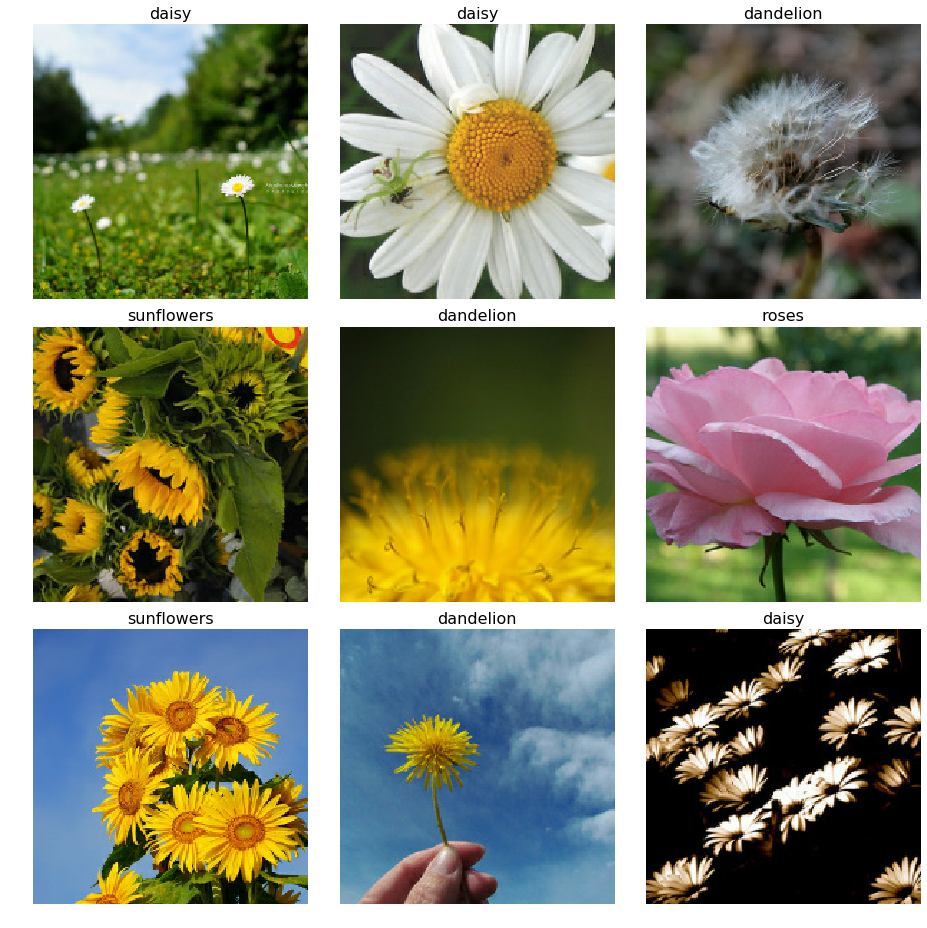

In [13]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [0]:
def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
  return dataset

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames)
validation_dataset = get_batched_dataset(validation_filenames)

## Model [WORK REQUIRED]
1. Start with a dummy single-layer model using one dense layer:
 * Use  a [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) model. The constructor takes a list of layers.
 * First, [`Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the pixel values of the the input image to a 1D vector so that a dense layer can consume it.:<br/>
 **`tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3])  # the first layer must also specify input shape`**
 * Add a single [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers):<br/>
  **`tf.keras.layers.Dense(5, activation='softmax')`**
 * add the last bits and pieces with [model.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#compile). For a classifier, you need **'sparse_categorical_crossentropy'** loss, **'accuracy'** in metrics and you can use the **'adam'** optimizer.
<p>==>Train this model: not very good... but all the plumbing is in place.</p>
1. Instead of trying to figure out a better architecture, we will adapt a pretrained model to our data. Please remove all your layers to restart from scratch.
 * Instantiate a pre-trained model from `tf.keras.applications.*`<br/>
 You do not need its final softmax layer (`include_top=False`) because you will be adding your own:<br/>
  **`pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)`**<br/>
  **`pretrained_model.trainable = False  # we do not want to change the pre-trained weights`**<br/>
  Use pretrained_model as your first "layer" in your Sequential model.
 * Add  [`tf.keras.layers.Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) or [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) to turn the data into a 1D vector.
 * Add your [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers).
 <p>** ==>Train the model: you should be able to reach 80-85% accuracy**</p>
1. You can try adding a second dense layer. Use 'relu' activation on all dense layers but the last one which must be 'softmax'. An additional layer ads trainable weights. It is unlikely to do much good here though, because our dataset is too small.

This technique is called "transfer learning". The pretrained model has been trained on a different dataset but its layers have still learned to recognize bits and pieces of images that can be useful for flowers. You are retraining the last layer only, the pretrained weights are frozen. With far fewer weights to adjust, it works with less data.

QUESTION 1:

In [14]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

model = tf.keras.Sequential([
  #
  # YOUR CODE HERE
  # 
    tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3]),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
  #
  # YOUR CODE HERE
  # 
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 110592)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 552965    
Total params: 552,965
Trainable params: 552,965
Non-trainable params: 0
_________________________________________________________________


## Training

In [15]:
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)

Epoch 1/5


W0623 03:03:03.893982 140341098891136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


46/46 [==============================] - 20s 425ms/step - loss: 12.3577 - acc: 0.1974 - val_loss: 13.2932 - val_acc: 0.1750
Epoch 2/5
46/46 [==============================] - 2s 35ms/step - loss: 12.7904 - acc: 0.2028 - val_loss: 12.5923 - val_acc: 0.2188
Epoch 3/5
46/46 [==============================] - 2s 34ms/step - loss: 12.6361 - acc: 0.2160 - val_loss: 12.5671 - val_acc: 0.2203
Epoch 4/5
46/46 [==============================] - 2s 38ms/step - loss: 12.6306 - acc: 0.2164 - val_loss: 12.6174 - val_acc: 0.2172
Epoch 5/5
46/46 [==============================] - 2s 33ms/step - loss: 12.6196 - acc: 0.2171 - val_loss: 12.6174 - val_acc: 0.2172


Very bad accuracy, only 0.217

QUESTION 2

In [18]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

model = tf.keras.Sequential([
  #
  # YOUR CODE HERE
  # 
    pretrained_model,
    tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3]),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
  #
  # YOUR CODE HERE
  # 
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 230,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)

Epoch 1/5
46/46 [==============================] - 18s 382ms/step - loss: 0.1357 - acc: 0.9769 - val_loss: 2.2053 - val_acc: 0.7453
Epoch 2/5
46/46 [==============================] - 5s 100ms/step - loss: 0.1053 - acc: 0.9827 - val_loss: 3.0712 - val_acc: 0.6875
Epoch 3/5
46/46 [==============================] - 4s 96ms/step - loss: 0.0972 - acc: 0.9868 - val_loss: 2.3215 - val_acc: 0.7563
Epoch 4/5
46/46 [==============================] - 5s 100ms/step - loss: 0.0905 - acc: 0.9854 - val_loss: 1.6275 - val_acc: 0.8031
Epoch 5/5
46/46 [==============================] - 4s 96ms/step - loss: 0.1080 - acc: 0.9837 - val_loss: 1.8982 - val_acc: 0.7781


Accuracy goes up to 98% but overfitting

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


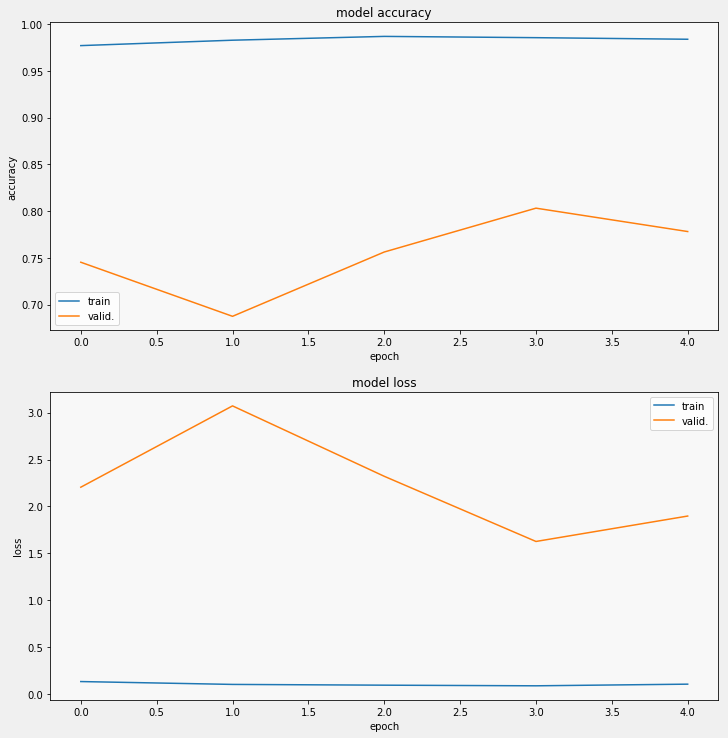

In [23]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [24]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

['daisy', 'tulips', 'daisy', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'tulips', 'roses']


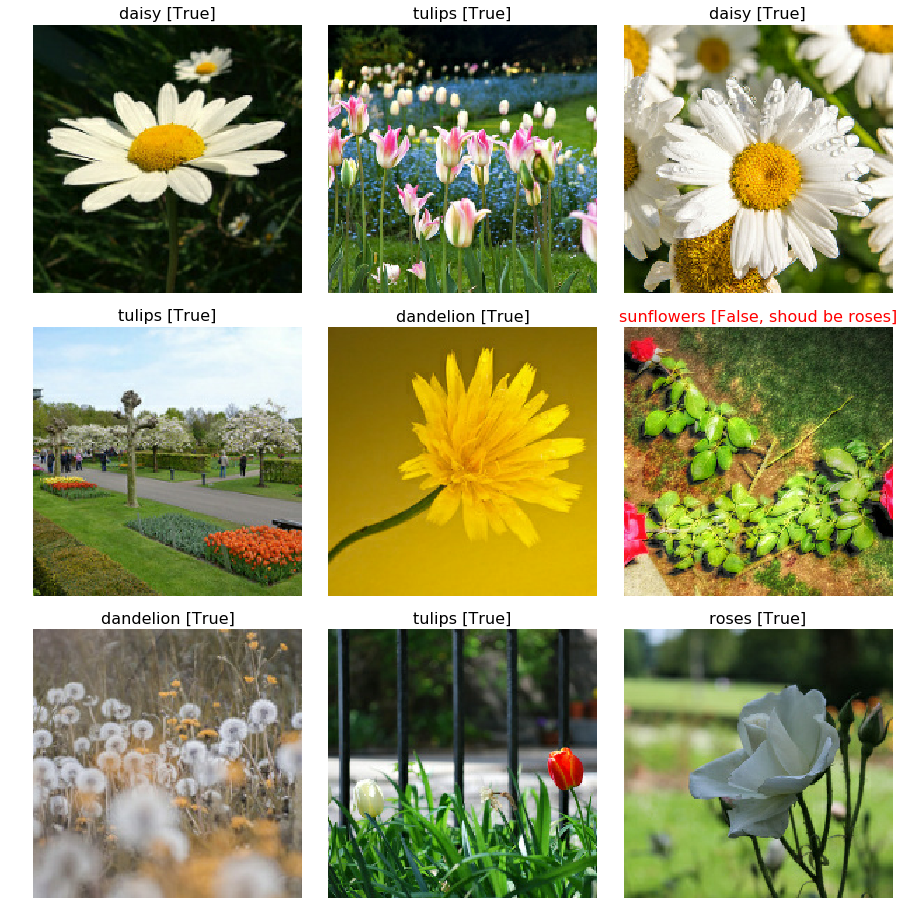

In [25]:
display_9_images_with_predictions(flowers, predictions, labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
